In [1]:
%run RSCM_v1.py 

# crop-specific parameters
cpara = {
    'Tbase'    : 10.0,      # Base temperature                                     
    'k'        : 0.65,      # Light extinction coefficient                             
    'RUE'      : 3.55,      # Radiation use efficiency                               
    'SLA'      : 0.016,     # Specific leaf area                                     
    'beta1'    : 0.45,      # Ratio of SR to PAR                                   
    'eGDD'     : 30.0,      # GDD at plant emergence                                
    'pd'       : 5          # parameter d (leaf senescence)
}

# ET-associated parameters
ET_para = {
    'a_ndvi'   : 0.60,     # conv. parameter a in NDVI = a * LAI ^ b, rice = 0.60 (Ko et al., 2015)
    'b_ndvi'   : 0.35,     # conv. parameter b in NDVI = a * LAI ^ b, rice = 0.35 (Ko et al., 2015) 
    'd_para1'  : 0.49,     # damping parameter (corr. between LAI & T/ET0), rice = 0.49 (Nay-Htoon et al, 2018)
    'd_para2'  : 0.8,      # damping parameter (corr. between NDVI & LAI), rice = 0.8 (Nay-Htoon et al, 2018)
    'VI_max'   : 5.0,      # max VI or LAI
    'VI_min'   : 0.01,     # min VI or LAI
    'kc_max'   : 1.2,      # max value of crop coefficient (Kc), rice = 1.2 (FAO 56, Allen et al., 1998)
    'ini_D'    : 20,       # init., initial crop development period : rice = 30 (FAO, Allen et al., 1998)
    'dev_D'    : 30,       # Dev., development period : rice = 30
    'mid_D'    : 30,       # mid., mid development period : rice = 80
    'late_D'   : 20,       # late, late development period : rice 40
    'k_ini'    : 1.05,     # initial Kc : rice = 1.05
    'k_mid'    : 1.20,     # mid Kc : rice = 1.20
    'k_end'    : 0.60,     # end Kc : rice = 0.90-60
    'fC_soil'  : 0.29,     # field capacity of the soil water (0.07 ~ 0.40), silt loam = 0.22-0.36
    'wiltPoint': 0.15,     # wilting point of the soil water (0.02 ~ 0.24), silt loam = 0.09-0.21
    'REW'      : 9.5,      # readily evaporated water (2 ~ 12 mm), silt loam = 8-11
    'kc_opt'   : 1,        # basal crop coeff. cal. option: 0 = FAO Kc, 1 =  VI based
    'ke_opt'   : 0,        # soil E parameter cal. option: 0 = using soil info, 1 = using VI
    'kr_opt'   : 1         # E reduction coeff. cal. option: 1 = flooded crops ; 2 >= dryland or irrigated crops
}

# productivity-associated parameters
ppara = {
    'pmGDD' : 730,      # GDD at plant maturity
    'fg1'   : 0.01,     # factor of grain partitioning 1 (0.01-0.05) ### OLD for rice = 10             
    'fg2'   : 0.01,     # factor of grain partitioning 2 (0.01-0.5) ### OLD for rice = 12            
    'a1'    : 0.0074,   # coeff of LUE (LUE_cint = a1 * LAI + b1, Xue et al., 2017)   
    'b1'    : 0.0107,   # coeff of LUE (LUE_cint = a1 * LAI + b1, Xue et al., 2017)   
    'a2'    : 8.571,    # coeff of max GPP (GPP_max = a2 * LAI + b2, Xue et al., 2017)
    'b2'    : 4.081     # coeff of max GPP (GPP_max = a2 * LAI + b2, Xue et al., 2017)  
}

# location parameters
lpara = {
    'lat'   : 34.0,     # Latitude of the site
    'elev'  : 14,       # Elevation of the site
    'k_Rs'  : 0.11      # Rad adj. coef. (default=0.17,inland=0.16,coast=0.19,Gwangju=0.09)
}

fmLAI    = 10        # factor of max LAI
start    = 140       # start, Start at planting
nrecords = 150       # maximum number of days allowed in simulation since the starting date
  
# Initial guesses of unknown parameters
pa    = 0.1       # parameter a (leaf growth)
pb    = 0.00125   # parameter b (leaf growth)
pc    = 0.00125   # parameter c (leaf senescence)
L0    = 0.02      # parameter L0 (Initial leaf area index)
rGDD  = 560      # parameter rGDD
para0 = np.array((pa, pb, pc, L0, rGDD))

# Under the Bayesian approach, Gaussian priors are applied to the transformed (a,b,c,L0,rGDD)
# Ranges of (a,b,c,L0) are [0,1], so logistic transform is applied
# Range of rGDD is (0,infty), so log transform is applied
prior_mean_tran = para0         # Choose the inversely transformed prior mean
prior_cov = np.diag(1/para0)    # Choose the covariance matrix of the prior


In [2]:
###########################################################
# --- Example that estimate the RSCM with LAI data ---
###########################################################

# Step 1
# Objective     : To estimate (a,b,c,L0,rGDD)
# obs_d         : Stores the observed data of LAIIs, not necessarily observed daily as matrix form.
# wx_data       : Stores the 365 daily obseravations of weather data
# bayOpt        : 0 = Not Bayesian, 1 = Bayesian
# ODOYLAI       : Observed DOYs and the corresponding LAI values

bayOpt = 0
obs_d = np.genfromtxt('Data/LAI_Daeryuk_maize_2021.OBS', dtype='float')                     # read VI obs data for parameter estimation
wx_data = np.genfromtxt('Data/Gwangju_2021.WXD', dtype='float')      # read weather data
print(wx_data)
# Notes: In Optim_GRAMI, the arguments prior_cov, prior_mean can be dropped if bayOpt = 0
(paraout,ODOYLAI) = Optim_RSCM_LAI(cpara,fmLAI,start,nrecords,wx_data,obs_d,para0,bayOpt,prior_cov,prior_mean_tran)
print(paraout)
print(ODOYLAI)

[[  1.    9.    3.5  -5.    0. ]
 [  2.   12.5   2.6  -3.2   0.5]
 [  3.   10.4   3.7  -3.5   0. ]
 ...
 [364.    4.4   6.3  -1.7   3.2]
 [365.    9.   -1.6  -8.6   0.7]
 [366.    9.4  -1.2 -10.    0.7]]
[6.02120636e-01 5.12463886e-03 4.43752850e-04 1.96350254e-02
 5.36750000e+02]
   ODOY  OLAI
0   159  0.61
1   178  1.59
2   195  2.10
3   204  2.14
4   209  2.05
5   217  2.07
6   228  1.63


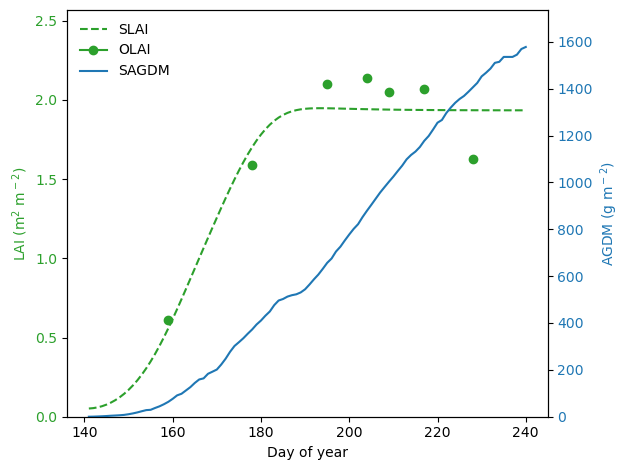

In [3]:
# Step 2
# Objective     : Simulate the GRAMI process and display the results
# wx_data       : Stores the 365 daily obseravations of weather data
# paraout       : Estimated parameters obtained in Step 1
# ODOYLAI       : Observed DOYs and the corresponding LAI values implied from VIs using coef, Sigma in Step 1

(cyield,GRAMIProcess)=sim_cG(paraout,ODOYLAI,ET_para,ppara,lpara,cpara,start,wx_data)

plot_cG(GRAMIProcess)

outf = open('Output/sim_cGrowth_Maize_LAI.out', 'w')
out_file_cG(outf,paraout,cyield,GRAMIProcess)
outf.close()

In [4]:
###########################################################
# --- Example that estimate the RSCM with VI data ---
###########################################################

# Step 1
# Objective     : To fit the regression model for VIs against LAI
# regressionOpt : 0 = log-log regression, 1 = tanh regression
# wobs_data     : Data as matrix containing both LAI and VI for fitting regression model
# coef, Sigma   : The regression coefficients and the covariance matrix of the error terms

regressionOpt = 0  
wobs_data = np.genfromtxt('Data/whole_VIs_LAI_maize_CNU_2021.OBS', dtype='float')

(coef, Sigma) = get_regr_coef_VI_LAI(wobs_data,regressionOpt)
print(coef)
print(Sigma)


[[-0.80845707  0.3761989 ]
 [-0.33846965  0.18850791]
 [-0.68921014  0.25241699]
 [-0.81286436  0.29271251]]
[[0.02009499 0.01088963 0.01320734 0.01529237]
 [0.01088963 0.00815153 0.00877785 0.00943656]
 [0.01320734 0.00877785 0.00988236 0.01090774]
 [0.01529237 0.00943656 0.01090774 0.01232772]]


In [ ]:
# Step 2
# Objective     : To imply LAI from the VI data without estimating (a,b,c,L0,rGDD)
#                 Goto Step 2' if want to imply LAI and estimate RSCM model simultaneously.
# obs_d         : Stores the observed data of VIs, not necessarily observed daily as matrix form.
# regressionOpt : Same as Step 1
# coef,Sigma    : Same as Step 1
# ODOYLAI       : Observed DOYs and the corresponding LAI values implied from VIs using coef, Sigma

obs_d = np.genfromtxt('Data/VIs_Dream_maize_2021.OBS', dtype='float') # read VI obs data for parameter estimation
ODOYLAI = get_LAI_from_VI(fmLAI,regressionOpt,coef,Sigma,obs_d)
print(ODOYLAI)


   ODOY      OLAI
0   159  0.670116
1   178  2.319743
2   195  2.171519
3   204  2.171292
4   209  2.525469
5   217  1.697804
6   228  1.356037


In [ ]:
# Step 2'
# Objective     : To imply LAI from the VI data and estimate (a,b,c,L0) simultaneously
# obs_d         : Stores the observed data of VIs, not necessarily observed daily as matrix form.
# wx_data       : Stores the 365 daily obseravations of weather data
# regressionOpt : Same as Step 1
# coef,Sigma    : Same as Step 1
# bayOpt        : 0 = Not Bayesian, 1 = Bayesian
# impliedLAIOpt : 0 = Estimate (a,b,c,L0) from VIs, 1 = Estimate (a,b,c,L0) from implied LAI
# paraout       : Estimated parameters
# ODOYLAI       : Observed DOYs and the corresponding LAI values implied from VIs using coef, Sigma
#'''
bayOpt        = 0
impliedLAIOpt = 0
obs_d = np.genfromtxt('Data/VIs_Dream_maize_2021.OBS', dtype='float')         # read VI obs data for parameter estimation
wx_data = np.genfromtxt('Data/Gwangju_2021.WXD', dtype='float') # read weather data

# Notes: In Optim_GRAMI, the arguments prior_cov, prior_mean can be dropped if bayOpt = 0
(paraout,ODOYLAI) = Optim_RSCM_VI(cpara,fmLAI,start,nrecords,wx_data,obs_d,para0,bayOpt,
                    regressionOpt,impliedLAIOpt,coef,Sigma,prior_cov,prior_mean_tran)
print(paraout)
print(ODOYLAI)
#'''

[1.00000000e+00 2.00488821e-03 2.81863280e-03 3.26662731e-02
 5.08033681e+02]
   ODOY      OLAI
0   159  0.670116
1   178  2.319743
2   195  2.171519
3   204  2.171292
4   209  2.525469
5   217  1.697804
6   228  1.356037


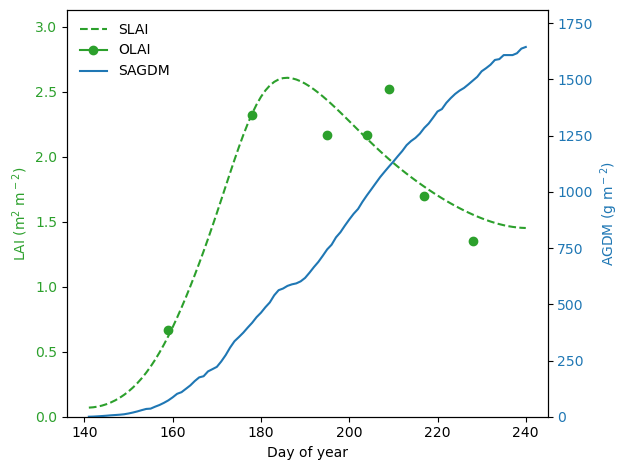

In [7]:
# Step 3
# Objective     : Simulate the GRAMI process and display the results
# wx_data       : Stores the 365 daily obseravations of weather data
# paraout       : Estimated parameters obtained in Step 2'
# ODOYLAI       : Observed DOYs and the corresponding LAI values implied from VIs using coef, Sigma in Step 2'
#'''
(cyield,GRAMIProcess)=sim_cG(paraout,ODOYLAI,ET_para,ppara,lpara,cpara,start,wx_data)

plot_cG(GRAMIProcess)

outf = open('Output/sim_cGrowth_Maize_VI.out', 'w')
out_file_cG(outf,paraout,cyield,GRAMIProcess)
outf.close()
#'''